For Part II of this assignment, I will investigate default rates using Kramers' escape formula. I will use tensorflow and set up a graph to minimise the negative log likelihood as given in the ipython notebook. 

I first optmise for thirty-four (34) parameters, with the following initial parameters:
- The theta value (0.0)
- The sigma value (1.0)
- The kappa value (0.0)
- The g value (0.0)
- The weights vector with thirty free parameters [0.0]x30

I also use the Adam Gradient Descent optmisation algorithm as this has a variable lerning rate which is applicable and useful in such a high dimensional space. 

I also normalise the data by first switching the raw data into log space, and then normalising by the initial mean market cap at time 0. This ensure that the model can converge efficiently and accurately. It improves model performace and is a tractable space transformation.

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [0]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')
####Take logs of the market caps
df_cap = np.log(df_cap)

In [0]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap = ((df_cap/np.mean(df_cap.iloc[0])))  #renormalise the market caps to all start with a number close to 1
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.029948,0.975192,0.968230,0.963754,1.017642,1.022018,0.984592,0.960248,1.023463,0.999109,...,0.949737,1.020527,1.026716,0.952164,0.963947,0.987959,0.968728,1.001511,1.032497,1.050714
2010-01-05,1.030017,0.975105,0.969507,0.964225,1.017465,1.022298,0.984493,0.961976,1.023667,0.999803,...,0.949894,1.019957,1.026729,0.951214,0.963884,0.987362,0.968272,1.001582,1.032101,1.050869
2010-01-06,1.029381,0.975741,0.970691,0.964345,1.017206,1.022303,0.984282,0.962672,1.023463,0.999378,...,0.949652,1.019830,1.026540,0.950647,0.964272,0.987154,0.967736,0.999857,1.032012,1.051210
2010-01-07,1.029308,0.976206,0.972264,0.964505,1.017384,1.022153,0.984295,0.962697,1.025463,1.000146,...,0.950617,1.019680,1.026325,0.951214,0.965765,0.987323,0.968103,0.999621,1.032034,1.051085
2010-01-08,1.029571,0.976178,0.971880,0.964947,1.017594,1.022223,0.984357,0.962837,1.026308,0.999389,...,0.950538,1.020000,1.026272,0.951157,0.965391,0.987402,0.968213,0.999646,1.031834,1.050926


In [0]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [0]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

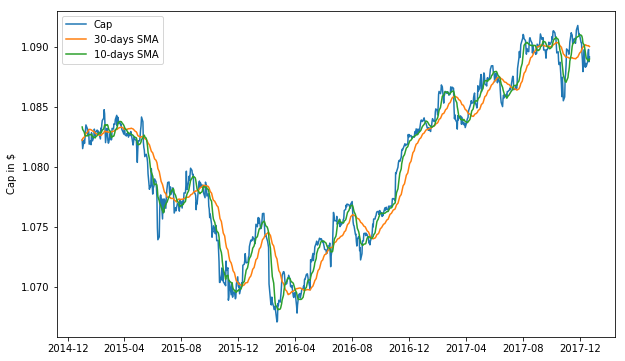

In [0]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

In [0]:
####Part 1
####Declaring Hyperparamters
learning_rate = 0.01
training_epochs = 50
training_steps = 38 
batch_length = 50
first_index = 100

####Declaring raw log data (i.e all timeseries start at 100)
times_data = np.arange(df_cap.shape[0]-1).astype(int)
stock_prices_data = np.array(df_cap).astype(float)
signals_data = np.array(short_rolling).astype(float)

####Declaring constant placeholders
times = tf.placeholder(tf.int32, shape=[None])  #times = tf.constant(np.arange(int(stock_prices_data.shape[0])), dtype = tf.int32)
stock_prices = tf.placeholder(tf.float32, shape=[None, None])  #stock_prices = tf.constant(np.array(df_cap), dtype = tf.float32)
signals = tf.placeholder(tf.float32, shape=[None, None])  #signals = tf.constant(np.array(short_rolling), dtype = tf.float32)

####Declaring variable placeholders
theta = tf.Variable(initial_value=0.0, dtype=tf.float32)
sigma = tf.Variable(initial_value=1.0, dtype=tf.float32)
kappa = tf.Variable(initial_value=0.0, dtype=tf.float32)
little_g = tf.Variable(initial_value=0.0, dtype=tf.float32)   
weights_vector = tf.Variable(initial_value=0.0*tf.ones(df_cap.shape[1], dtype=tf.float32), dtype=tf.float32)

####Declaring Lambda functions
def delta_V_over_delta_y_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices):
    """
    delta_V_over_delta_y_t - compute the partial derivative of V with respect to y that is used in the minimum likelihood equation.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    Return:
    delta_V_over_delta_y_t_function - a lambda function which returns the partial derivative vector at a given time index
    """
    delta_V_over_delta_y_t_function = lambda index:  (((tf.pow(sigma, 2)/2.0) - theta -  (tf.tensordot( weights_vector,tf.squeeze(tf.gather(signals, [index])),1)))*tf.ones(30, dtype=tf.float32)  ) + (kappa*tf.exp(tf.squeeze(tf.gather(stock_prices, [index])))) + (little_g*tf.exp(2.0*tf.squeeze(tf.gather(stock_prices, [index]))))
    return delta_V_over_delta_y_t_function 

def neg_log_likelihood_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices):
    """
    neg_log_likelihood_t - compute the negative log likelihood scalar that is minimised in the optimisation.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    Return:
    neg_log_likelihood_t_function - a lambda function which returns the log_likelihood scalar function at a given time index
    """ 
    delta_V_over_delta_y_time = delta_V_over_delta_y_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices)
    ####ignore 2pi term as it is a constant and does blow up 
    neg_log_likelihood_t_function = lambda index: tf.log(tf.abs(sigma)) + ( (1.0/(2.0*sigma*sigma)) * ((tf.norm(((((tf.squeeze(tf.gather(stock_prices, [index+1])) - tf.squeeze(tf.gather(stock_prices, [index]))))   ) ) + delta_V_over_delta_y_time(index)))**2))
    return neg_log_likelihood_t_function

def log_likelihood(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices, times):
    """
    log_likelihood - compute the summed negative log likelihood scalar that is the sum over times of neg_log_likelihood_t.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    times - a tensorflow object that represents the vector of indices for which we sum across
    Return:
    LL_theta_t_map_result_remove_nans - a scalar of the negative log likelihood function across indices in times
    """ 
    LL_theta_t = neg_log_likelihood_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices)
    LL_theta_t_map_result = tf.map_fn(LL_theta_t, times, dtype=tf.float32)
    LL_theta_t_map_result_remove_nans = tf.where(tf.is_nan(LL_theta_t_map_result), tf.zeros_like(LL_theta_t_map_result), LL_theta_t_map_result)
    return LL_theta_t_map_result_remove_nans
    
####Creating the log sum and creating the error term
LL_theta_t_map_result_remove_nans = log_likelihood(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices, times)
error = tf.reduce_sum(LL_theta_t_map_result_remove_nans, 0)

####Gradient of the log likelihood
grad = tf.gradients(error, [theta, sigma, kappa, little_g])
grad_weights = tf.gradients(error, [weights_vector])

####The Adam Gradient Descent Optimizer does the heavy lifting
train_op = tf.train.AdamOptimizer(learning_rate).minimize(error)

####Normal TensorFlow - initialize values, create a session and run the model
model = tf.global_variables_initializer()

####Summaries
tf.summary.scalar("loss",error)
merged_summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(model)
        
    print("starting at", "theta:", sess.run(theta))
    print("starting at", "sigma:", sess.run(sigma))
    print("starting at", "kappa:", sess.run(kappa))
    print("starting at", "g:", sess.run(little_g))
    print("starting at", "weights:", sess.run(weights_vector)) 

    obs_theta, obs_sigma, obs_kappa, obs_little_g, obs_weights_vector = sess.run(fetches=[theta, sigma, kappa, little_g, weights_vector])
    
    errors = np.array([1])
    gradients = np.empty(shape=[4])
    gradients_weights = np.empty(shape=[30])

    for epoch in range(training_epochs):
        for step in range(training_steps):
            stock_prices_data = np.array(df_cap).astype(float)
            signals_data = np.array(short_rolling).astype(float)
            starting_index = first_index + step*batch_length
            times_data = np.arange(df_cap.shape[0]-1).astype(int)[starting_index:starting_index+batch_length]
            print(epoch, starting_index, starting_index+batch_length)
            op, numerical_error, summary = sess.run([train_op, error, merged_summary_op], feed_dict={stock_prices: stock_prices_data, signals: signals_data, times: times_data})
            print("numerical_error:", numerical_error)
            
            new_obs_theta, new_obs_sigma, new_obs_kappa, new_obs_little_g, new_obs_weights_vector = sess.run(fetches=[theta, sigma, kappa, little_g, weights_vector])
            numerical_error = sess.run(fetches=error, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            new_gradients = sess.run(fetches=grad, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            new_gradients_weights = sess.run(fetches=grad_weights, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            
            errors = np.append(errors, numerical_error)
            obs_theta = np.append(obs_theta, new_obs_theta)
            obs_sigma = np.append(obs_sigma, new_obs_sigma)
            obs_kappa = np.append(obs_kappa, new_obs_kappa)
            obs_little_g = np.append(obs_little_g, new_obs_little_g)
            obs_weights_vector = np.vstack([obs_weights_vector, new_obs_weights_vector])
            gradients = np.vstack([gradients,new_gradients])
            gradients_weights = np.vstack([gradients_weights,new_gradients_weights])
            print(new_obs_theta, new_obs_sigma, new_obs_kappa, new_obs_little_g, new_obs_weights_vector[0])
            
    print("ending at", "theta:", sess.run(theta))
    print("ending at", "sigma:", sess.run(sigma))
    print("ending at", "kappa:", sess.run(kappa))
    print("ending at", "g:", sess.run(little_g))
    print("ending at", "weights:", sess.run(weights_vector))      
    print("ending at", "error:", sess.run(error, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data}))
    
    sess.close()



starting at theta: 0.0
starting at sigma: 1.0
starting at kappa: 0.0
starting at g: 0.0
starting at weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
0 100 150
numerical_error: 187.51764
0.009999999 0.99 -0.01 -0.01 0.009999999
0 150 200
numerical_error: 4.321202
0.017803015 0.98109865 -0.017802326 -0.01780164 0.017804444
0 200 250
numerical_error: 48.692936
0.020220922 0.9805603 -0.020204328 -0.020187754 0.020196542
0 250 300
numerical_error: 96.74466
0.018730976 0.98455626 -0.018688658 -0.018646372 0.018662587
0 300 350
numerical_error: 63.398117
0.015388361 0.9901574 -0.015318637 -0.015249017 0.015274397
0 350 400
numerical_error: 15.161461
0.011552471 0.99585503 -0.01145615 -0.011360024 0.011394536
0 400 450
numerical_error: 0.2693376
0.008369914 1.0004145 -0.008249069 -0.00812851 0.008175299
0 450 500
numerical_error: 19.295553
0.0066565806 1.0032115 -0.0065147593 -0.0063733314 0.0064423345
0 500 550
numerical_error: 40.84062
0.0

numerical_error: -7.4072094
0.009071884 0.8574462 -0.008255504 -0.007435342 0.009592451
2 450 500
numerical_error: -7.582613
0.009090829 0.8538746 -0.00826127 -0.0074278642 0.009613596
2 500 550
numerical_error: -7.862167
0.009168656 0.8502208 -0.0083258115 -0.0074790563 0.009693849
2 550 600
numerical_error: -8.091708
0.009207292 0.8465658 -0.008350905 -0.007490537 0.009734124
2 600 650
numerical_error: -8.271834
0.009157616 0.84295017 -0.008287369 -0.0074130693 0.009684485
2 650 700
numerical_error: -8.462713
0.009006139 0.83938473 -0.008121421 -0.007232558 0.009530737
2 700 750
numerical_error: -8.721033
0.008811925 0.8358198 -0.0079124505 -0.007008738 0.0093334755
2 750 800
numerical_error: -8.953425
0.008646277 0.8321968 -0.007732155 -0.006813698 0.009165184
2 800 850
numerical_error: -9.155065
0.008553717 0.8284801 -0.007625441 -0.0066927252 0.00907059
2 850 900
numerical_error: -9.376509
0.008532842 0.8246713 -0.0075910357 -0.0066446774 0.009048237
2 900 950
numerical_error: -9.

0.0031198887 0.42861646 -0.0012910977 0.00055371574 0.0035188613
4 700 750
numerical_error: -42.35519
0.0029525706 0.42041585 -0.0011191608 0.00073031156 0.003347156
4 750 800
numerical_error: -43.294327
0.003008188 0.41200328 -0.0011718716 0.00068055803 0.003400936
4 800 850
numerical_error: -44.287964
0.0027941188 0.40354547 -0.00095383293 0.00090258697 0.0031835642
4 850 900
numerical_error: -45.34999
0.0027853467 0.39487368 -0.00094357895 0.00091435015 0.0031728663
4 900 950
numerical_error: -46.454315
0.0026984205 0.38607553 -0.00085527694 0.0010040345 0.0030835238
4 950 1000
numerical_error: -47.582355
0.0025582465 0.3771355 -0.0007140486 0.001146303 0.0029404273
4 1000 1050
numerical_error: -48.738235
0.0026057085 0.36797252 -0.0007632722 0.0010953078 0.0029874002
4 1050 1100
numerical_error: -49.90829
0.0022632391 0.35875592 -0.0004190191 0.00144129 0.00263967
4 1100 1150
numerical_error: -50.93454
0.0027581882 0.34912926 -0.000923997 0.00092622155 0.003143961
4 1150 1200
numer

numerical_error: -60.736683
0.006535897 0.23531571 -0.004632641 -0.0027222103 0.0063064783
6 950 1000
numerical_error: 438.0065
0.005411892 0.25332823 -0.0035142894 -0.0016096779 0.005150831
6 1000 1050
numerical_error: 170.20961
0.0015893651 0.2714261 0.0003143882 0.002224747 0.0012956194
6 1050 1100
numerical_error: -60.12156
-0.0014723262 0.2875363 0.0033793878 0.0052927164 -0.0017948546
6 1100 1150
numerical_error: 157.66519
-0.001829118 0.30249286 0.0037236516 0.0056242705 -0.0021610796
6 1150 1200
numerical_error: 190.26825
0.0002291887 0.31647 0.001639151 0.0035134961 -8.937484e-05
6 1200 1250
numerical_error: 5.156814
0.0032167241 0.32892185 -0.0013796275 0.00046344334 0.0029234234
6 1250 1300
numerical_error: -48.713043
0.00554776 0.34018046 -0.0037362718 -0.0019188488 0.0052721696
6 1300 1350
numerical_error: 50.462196
0.0062774015 0.3511386 -0.004478847 -0.0026744383 0.005994264
6 1350 1400
numerical_error: 92.60438
0.0053795264 0.3620673 -0.0035813341 -0.0017774196 0.005063

0.0034541213 0.41965818 -0.0014033926 0.00065191195 0.0020876024
8 1150 1200
numerical_error: -43.33732
0.0034498714 0.41860625 -0.001399257 0.0006559225 0.0020844175
8 1200 1250
numerical_error: -43.47014
0.0034785874 0.4175352 -0.0014283053 0.00062653306 0.0021144564
8 1250 1300
numerical_error: -43.64515
0.003523196 0.41645184 -0.0014733693 0.0005810061 0.002160508
8 1300 1350
numerical_error: -43.798164
0.0035632006 0.41536456 -0.001513808 0.000540126 0.0022018095
8 1350 1400
numerical_error: -43.907978
0.0035810838 0.4142806 -0.0015319793 0.0005216592 0.0022205617
8 1400 1450
numerical_error: -44.013474
0.0035706582 0.4132026 -0.0015217189 0.000531745 0.0022105933
8 1450 1500
numerical_error: -44.14233
0.0035339433 0.41212985 -0.0014850163 0.0005684255 0.0021739642
8 1500 1550
numerical_error: -44.299194
0.0034833497 0.41105717 -0.0014343996 0.00061905565 0.0021233354
8 1550 1600
numerical_error: -44.4492
0.0034337982 0.4099786 -0.0013848334 0.00066862756 0.002073723
8 1600 1650
n

0.0026401205 0.3169865 -0.0006446498 0.0013552657 0.0012690445
10 1350 1400
numerical_error: -57.44165
0.0026319963 0.3154092 -0.0006382242 0.0013599838 0.0012608764
10 1400 1450
numerical_error: -57.688267
0.0026205904 0.31382334 -0.0006285181 0.0013679803 0.0012493787
10 1450 1500
numerical_error: -57.941166
0.0026054084 0.31222892 -0.0006150429 0.0013797376 0.0012340543
10 1500 1550
numerical_error: -58.194473
0.0025884658 0.31062523 -0.0005998439 0.0013931823 0.0012169584
10 1550 1600
numerical_error: -58.454956
0.0025729684 0.3090111 -0.0005861308 0.0014051002 0.0012013207
10 1600 1650
numerical_error: -58.71485
0.0025606758 0.3073859 -0.0005756882 0.0014136817 0.0011889078
10 1650 1700
numerical_error: -58.979134
0.00254933 0.30575013 -0.0005662447 0.0014212102 0.0011774517
10 1700 1750
numerical_error: -59.24546
0.0025393404 0.30410355 -0.0005581993 0.0014272976 0.001167364
10 1750 1800
numerical_error: -59.515965
0.0025274546 0.30244696 -0.000548269 0.0014352562 0.0011553577
10

numerical_error: -97.39367
0.0014985285 0.13899621 0.00011019142 0.0017233326 0.00012160445
12 1550 1600
numerical_error: -98.63392
0.0015110475 0.13544665 8.547644e-05 0.0016863495 0.000134185
12 1600 1650
numerical_error: -99.90248
0.0014412797 0.1318325 0.000142975 0.0017315026 6.413809e-05
12 1650 1700
numerical_error: -101.20327
0.0015194156 0.1281205 5.090944e-05 0.0016254203 0.00014309045
12 1700 1750
numerical_error: -102.40046
0.0013033856 0.12436457 0.00025449906 0.001816468 -7.482972e-05
12 1750 1800
numerical_error: -102.531006
0.0017929723 0.120463386 -0.00025452665 0.0012878831 0.00042088726
12 1800 1850
numerical_error: -92.91911
0.00027424155 0.11694281 0.0012646539 0.002807402 -0.0011249636
12 1850 1900
numerical_error: 21.391497
0.0050423965 0.11511697 -0.0035644735 -0.0020827749 0.0037232153
12 1900 1950
numerical_error: 1265.3579
-0.006060657 0.13062857 0.007589371 0.009120928 -0.0074815787
12 1950 2000
numerical_error: 4376.6074
0.0021707918 0.15445973 -0.000689990

numerical_error: -34.36774
0.0014180935 0.49765322 -0.002093466 -0.0027276904 0.0028704735
14 1750 1800
numerical_error: -34.524616
0.0014820958 0.49739718 -0.0021569536 -0.0027906473 0.0029339984
14 1800 1850
numerical_error: -34.724556
0.0015640932 0.49713197 -0.002238483 -0.0028716887 0.0030157473
14 1850 1900
numerical_error: -34.885468
0.0016510084 0.49686137 -0.0023249302 -0.0029576463 0.0031025591
14 1900 1950
numerical_error: -34.964806
0.0017299581 0.49658918 -0.0024033578 -0.0030355304 0.0031814226
14 1950 2000
numerical_error: -34.95164
0.0017895742 0.4963189 -0.0024623098 -0.0030937996 0.0032408193
15 100 150
numerical_error: -35.010914
0.0018381836 0.4960485 -0.0025103048 -0.003141167 0.0032894101
15 150 200
numerical_error: -35.00012
0.0018698074 0.49577993 -0.0025414876 -0.0031718994 0.003321426
15 200 250
numerical_error: -34.973232
0.001880359 0.49551457 -0.0025518208 -0.0031820075 0.0033328251
15 250 300
numerical_error: -34.96476
0.0018690139 0.49525288 -0.0025404578

0.0014316825 0.4745161 -0.0020308897 -0.00258979 0.0028945983
16 1900 1950
numerical_error: -37.265854
0.0014243949 0.47419915 -0.0020224596 -0.0025802206 0.0028872213
16 1950 2000
numerical_error: -37.300144
0.0014155564 0.47388208 -0.0020124696 -0.0025690799 0.002878274
17 100 150
numerical_error: -37.285236
0.0014216988 0.4735606 -0.0020171711 -0.002572351 0.0028838234
17 150 200
numerical_error: -37.331036
0.0014395845 0.47323558 -0.002033401 -0.002586943 0.0029007574
17 200 250
numerical_error: -37.38709
0.001463686 0.47290838 -0.002055759 -0.0026075793 0.002923781
17 250 300
numerical_error: -37.434727
0.0014882437 0.47258052 -0.0020785793 -0.002628686 0.0029472988
17 300 350
numerical_error: -37.470566
0.001508586 0.4722532 -0.0020972576 -0.0026457252 0.0029667465
17 350 400
numerical_error: -37.498177
0.0015212647 0.47192731 -0.0021083986 -0.0026553536 0.00297875
17 400 450
numerical_error: -37.528694
0.0015266255 0.47160277 -0.0021123493 -0.0026579204 0.002983621
17 450 500
nu

numerical_error: -40.14913
0.0011966614 0.44725505 -0.0016955865 -0.0021554856 0.0026373086
19 200 250
numerical_error: -40.21154
0.0012206524 0.44688305 -0.0017177206 -0.0021757863 0.002660059
19 250 300
numerical_error: -40.266304
0.0012452159 0.44651026 -0.0017404419 -0.0021966905 0.0026834332
19 300 350
numerical_error: -40.308334
0.0012647134 0.44613802 -0.0017581914 -0.0022127184 0.0027019219
19 350 400
numerical_error: -40.341576
0.0012750741 0.4457674 -0.00176696 -0.0022199217 0.0027115408
19 400 450
numerical_error: -40.379196
0.0012768557 0.4453982 -0.001767308 -0.002218863 0.0027128016
19 450 500
numerical_error: -40.416496
0.0012690976 0.44503072 -0.0017582707 -0.0022085733 0.0027047503
19 500 550
numerical_error: -40.456215
0.0012517796 0.44466493 -0.0017397975 -0.0021889717 0.002687304
19 550 600
numerical_error: -40.50119
0.0012270055 0.4443003 -0.0017139494 -0.0021620756 0.0026624475
19 600 650
numerical_error: -40.55407
0.0012004332 0.44393545 -0.0016863247 -0.00213342

0.0010187076 0.41623843 -0.001414784 -0.0017732339 0.0024357804
21 350 400
numerical_error: -43.796177
0.0010227523 0.4158147 -0.0014173377 -0.0017743238 0.002439238
21 400 450
numerical_error: -43.846157
0.0010137869 0.41539314 -0.001407123 -0.0017628857 0.0024299903
21 450 500
numerical_error: -43.899662
0.0009934034 0.4149734 -0.0013856755 -0.0017403994 0.002409584
21 500 550
numerical_error: -43.95839
0.00096467265 0.41455477 -0.0013559873 -0.0017097789 0.0023809685
21 550 600
numerical_error: -44.01804
0.00093259633 0.41413608 -0.0013229868 -0.0016758791 0.0023490184
21 600 650
numerical_error: -44.073505
0.000905082 0.4137155 -0.0012944919 -0.001646429 0.0023216119
21 650 700
numerical_error: -44.11978
0.00088645716 0.4132921 -0.0012747777 -0.001625651 0.002303086
21 700 750
numerical_error: -44.163197
0.00087933877 0.41286528 -0.0012664363 -0.001616113 0.0022960184
21 750 800
numerical_error: -44.214596
0.0008829731 0.4124352 -0.0012687595 -0.0016171503 0.0022995921
21 800 850
n

numerical_error: -48.276943
0.00065432943 0.3802296 -0.0009589629 -0.001227351 0.002072239
23 500 550
numerical_error: -48.346107
0.0006288909 0.37974 -0.0009327348 -0.0012003559 0.002047226
23 550 600
numerical_error: -48.408127
0.00061051664 0.37924787 -0.00091348233 -0.0011802479 0.002029218
23 600 650
numerical_error: -48.465317
0.00060380914 0.37875226 -0.0009057458 -0.0011715061 0.0020228003
23 650 700
numerical_error: -48.53116
0.0006076412 0.37825343 -0.00090841844 -0.0011730443 0.0020268965
23 700 750
numerical_error: -48.60064
0.0006185532 0.37775204 -0.00091807696 -0.0011814745 0.0020380167
23 750 800
numerical_error: -48.67234
0.00063097844 0.37724927 -0.00092923833 -0.0011913965 0.0020506026
23 800 850
numerical_error: -48.738003
0.0006382929 0.37674648 -0.0009353327 -0.001196295 0.0020581183
23 850 900
numerical_error: -48.79841
0.000635899 0.3762446 -0.00093178183 -0.0011916122 0.00205604
23 900 950
numerical_error: -48.86383
0.00062395073 0.37574366 -0.00091874256 -0.00

0.0002963332 0.33819276 -0.0005203783 -0.00070945587 0.00171689
25 600 650
numerical_error: -54.195496
0.00030304902 0.33760014 -0.0005259961 -0.0007139986 0.001723594
25 650 700
numerical_error: -54.29005
0.00031515758 0.33700505 -0.0005369464 -0.00072381395 0.0017356935
25 700 750
numerical_error: -54.380028
0.0003253995 0.3364088 -0.00054604234 -0.0007317868 0.0017459288
25 750 800
numerical_error: -54.465946
0.00032784388 0.33581248 -0.0005474222 -0.0007321246 0.0017484406
25 800 850
numerical_error: -54.54911
0.00031886954 0.33521676 -0.0005374746 -0.00072122674 0.0017396901
25 850 900
numerical_error: -54.63802
0.0002995897 0.33462143 -0.00051729096 -0.00070016325 0.0017207796
25 900 950
numerical_error: -54.73366
0.00027677946 0.33402523 -0.00049361365 -0.0006756428 0.0016983692
25 950 1000
numerical_error: -54.824844
0.00025791128 0.33342677 -0.00047388423 -0.000655074 0.0016798454
25 1000 1050
numerical_error: -54.910526
0.0002476381 0.33282518 -0.00046274142 -0.00064308016 0.

numerical_error: -62.28124
-1.8439669e-05 0.28698426 -0.0001445285 -0.00027351824 0.0013998874
27 700 750
numerical_error: -62.40984
-3.589885e-05 0.2862508 -0.00012658317 -0.00025509982 0.0013823146
27 750 800
numerical_error: -62.542046
-5.334687e-05 0.28551495 -0.00010866177 -0.00023671753 0.0013647837
27 800 850
numerical_error: -62.669853
-6.491721e-05 0.28477576 -9.6591524e-05 -0.00022415881 0.0013530779
27 850 900
numerical_error: -62.79876
-6.935085e-05 0.28403303 -9.1636226e-05 -0.00021869177 0.001348431
27 900 950
numerical_error: -62.93005
-6.815045e-05 0.283287 -9.2296825e-05 -0.00021882122 0.0013493772
27 950 1000
numerical_error: -63.062775
-6.5924534e-05 0.28253832 -9.399902e-05 -0.00022000761 0.0013513633
27 1000 1050
numerical_error: -63.192657
-6.845159e-05 0.28178793 -9.0974456e-05 -0.00021649383 0.0013486576
27 1050 1100
numerical_error: -63.326077
-7.7902645e-05 0.28103614 -8.105902e-05 -0.00020612359 0.0013391061
27 1100 1150
numerical_error: -63.46135
-9.1429516e

numerical_error: -75.31403
-0.0004023876 0.22072124 0.00025694675 0.0001450231 0.0009988246
29 800 850
numerical_error: -75.52262
-0.00041381177 0.2197231 0.0002681211 0.00015594513 0.0009875672
29 850 900
numerical_error: -75.753105
-0.00044731685 0.21872267 0.00030123309 0.0001886588 0.0009545596
29 900 950
numerical_error: -75.99338
-0.00047123546 0.21771602 0.0003247855 0.0002118419 0.00093101466
29 950 1000
numerical_error: -76.20852
-0.0004658254 0.2167008 0.00031907472 0.00020583374 0.000936517
29 1000 1050
numerical_error: -76.45203
-0.0004476107 0.21567889 0.0003005729 0.00018705199 0.00095469895
29 1050 1100
numerical_error: -76.69037
-0.00044594178 0.21465369 0.00029854785 0.00018467403 0.00095646235
29 1100 1150
numerical_error: -76.9223
-0.00046795091 0.21362598 0.00032015136 0.00020586955 0.00093461777
29 1150 1200
numerical_error: -77.172646
-0.0004938492 0.21259333 0.00034561104 0.00023088724 0.0009088712
29 1200 1250
numerical_error: -77.40607
-0.00049839186 0.21155277

-0.00090390135 0.119506635 0.00063404854 0.00039919937 0.00049879705
31 900 950
numerical_error: -106.19941
-0.000894582 0.11768565 0.00062088994 0.00038227544 0.0005083095
31 950 1000
numerical_error: -106.97058
-0.0009114894 0.115841486 0.0006337813 0.0003912158 0.0004918029
31 1000 1050
numerical_error: -107.75423
-0.0009170324 0.11397082 0.0006353044 0.0003887856 0.00048653194
31 1050 1100
numerical_error: -108.57789
-0.00092205714 0.11207326 0.00063619384 0.00038560215 0.00048175146
31 1100 1150
numerical_error: -109.42031
-0.0009348567 0.1101482 0.0006447254 0.00038992104 0.00046919406
31 1150 1200
numerical_error: -110.28275
-0.00093388703 0.10819321 0.00063937274 0.00038023858 0.00047036947
31 1200 1250
numerical_error: -111.16878
-0.0009535353 0.106209196 0.0006545511 0.00039098976 0.00045085236
31 1250 1300
numerical_error: -112.089386
-0.0009345824 0.104191385 0.00063098065 0.0003628484 0.00047007314
31 1300 1350
numerical_error: -113.015175
-0.0010145202 0.10214653 0.000706

numerical_error: -25.038092
0.0010575968 0.58989733 -0.0026208633 -0.0041294107 0.005404559
33 1100 1150
numerical_error: -25.062798
0.0010970196 0.5898267 -0.0026612997 -0.004170824 0.0054449406
33 1150 1200
numerical_error: -25.261847
0.0011721528 0.5897412 -0.0027372525 -0.004247561 0.005520999
33 1200 1250
numerical_error: -25.574186
0.0012736756 0.5896434 -0.002839438 -0.004350375 0.0056234966
33 1250 1300
numerical_error: -25.921509
0.0013910672 0.58953625 -0.0029573655 -0.004468805 0.0057419315
33 1300 1350
numerical_error: -26.203798
0.0015138814 0.5894225 -0.0030805925 -0.004592414 0.005865848
33 1350 1400
numerical_error: -26.378136
0.0016323011 0.5893049 -0.0031993035 -0.004711387 0.005985335
33 1400 1450
numerical_error: -26.43026
0.0017387908 0.5891856 -0.0033059663 -0.0048181973 0.006092784
33 1450 1500
numerical_error: -26.387148
0.0018260361 0.58906674 -0.0033932764 -0.00490555 0.0061808503
33 1500 1550
numerical_error: -26.299582
0.0018900906 0.58894974 -0.0034573264 -

numerical_error: -27.2543
0.0014988511 0.5795166 -0.0029824325 -0.0044121128 0.0058264397
35 1300 1350
numerical_error: -27.26625
0.0014958665 0.5793742 -0.0029784958 -0.0044072326 0.0058234828
35 1350 1400
numerical_error: -27.278732
0.0014953715 0.5792311 -0.0029770536 -0.0044048503 0.0058230334
35 1400 1450
numerical_error: -27.28752
0.0014979584 0.57908714 -0.002978691 -0.0044055446 0.0058256765
35 1450 1500
numerical_error: -27.3032
0.0015024609 0.57894266 -0.0029822458 -0.004408158 0.00583024
35 1500 1550
numerical_error: -27.314007
0.0015089164 0.5787976 -0.0029877445 -0.004412706 0.005836747
35 1550 1600
numerical_error: -27.329994
0.0015159365 0.5786522 -0.002993805 -0.004417813 0.005843814
35 1600 1650
numerical_error: -27.343369
0.0015226618 0.57850677 -0.0029995686 -0.0044226204 0.00585058
35 1650 1700
numerical_error: -27.355692
0.001527927 0.5783616 -0.003003868 -0.0044259597 0.0058558816
35 1700 1750
numerical_error: -27.367466
0.001531486 0.5782166 -0.0030064574 -0.0044

numerical_error: -28.287243
0.0013999732 0.56766653 -0.0027949691 -0.0041371463 0.0057093753
37 1500 1550
numerical_error: -28.300093
0.0014087318 0.56751055 -0.0028027568 -0.004143969 0.0057181823
37 1550 1600
numerical_error: -28.316229
0.0014168668 0.56735456 -0.0028099173 -0.004150161 0.0057263607
37 1600 1650
numerical_error: -28.329735
0.0014234602 0.56719875 -0.0028155327 -0.0041548046 0.005732995
37 1650 1700
numerical_error: -28.34163
0.0014273762 0.5670434 -0.0028184648 -0.004156758 0.005736947
37 1700 1750
numerical_error: -28.35427
0.0014285588 0.5668885 -0.0028186576 -0.0041559665 0.005738157
37 1750 1800
numerical_error: -28.364788
0.0014260774 0.5667343 -0.0028151765 -0.0041514905 0.005735684
37 1800 1850
numerical_error: -28.375982
0.0014196774 0.56658083 -0.0028077618 -0.004143065 0.005729251
37 1850 1900
numerical_error: -28.3902
0.0014099373 0.56642795 -0.0027969927 -0.004131269 0.0057194354
37 1900 1950
numerical_error: -28.403204
0.0013973161 0.56627554 -0.00278332

numerical_error: -29.421711
0.0013120836 0.5549018 -0.0026158846 -0.0038679698 0.0056001665
39 1700 1750
numerical_error: -29.436287
0.0013095395 0.5547364 -0.002612332 -0.0038634143 0.0055976314
39 1750 1800
numerical_error: -29.44894
0.0013034184 0.5545716 -0.0026051917 -0.0038552596 0.005591501
39 1800 1850
numerical_error: -29.462803
0.0012937665 0.5544075 -0.0025945057 -0.0038435436 0.0055818
39 1850 1900
numerical_error: -29.479336
0.0012814589 0.55424374 -0.0025811512 -0.003829145 0.0055694063
39 1900 1950
numerical_error: -29.494307
0.0012671654 0.5540803 -0.0025657988 -0.0038127347 0.005554993
39 1950 2000
numerical_error: -29.51036
0.0012510694 0.5539171 -0.0025486283 -0.003794489 0.005538742
40 100 150
numerical_error: -29.461893
0.0012486551 0.5537508 -0.002544898 -0.003789452 0.0055357907
40 150 200
numerical_error: -29.479927
0.0012583286 0.5535818 -0.0025530532 -0.0037961064 0.005544607
40 200 250
numerical_error: -29.516369
0.0012767682 0.5534107 -0.002569859 -0.0038113

numerical_error: -30.676428
0.0011417562 0.5411603 -0.002352964 -0.0035135588 0.005405401
41 1900 1950
numerical_error: -30.69258
0.0011278649 0.5409843 -0.002338016 -0.003497555 0.005391402
41 1950 2000
numerical_error: -30.710194
0.0011133085 0.5408082 -0.0023223956 -0.0034808698 0.005376719
42 100 150
numerical_error: -30.650307
0.0011141149 0.5406288 -0.0023218577 -0.0034789979 0.0053769536
42 150 200
numerical_error: -30.673641
0.0011281762 0.5404464 -0.002334346 -0.0034899318 0.0053900797
42 200 250
numerical_error: -30.716688
0.0011514361 0.5402619 -0.002355907 -0.003509818 0.005412229
42 250 300
numerical_error: -30.757727
0.0011794833 0.54007626 -0.0023822088 -0.003534401 0.00543912
42 300 350
numerical_error: -30.789537
0.0012083844 0.5398902 -0.0024093764 -0.003559863 0.005466901
42 350 400
numerical_error: -30.811844
0.001234675 0.53970456 -0.002433993 -0.003582834 0.005492176
42 400 450
numerical_error: -30.826153
0.0012573935 0.5395195 -0.0024551 -0.003602359 0.0055139964

numerical_error: -32.000004
0.000997843 0.526319 -0.002115855 -0.0031843511 0.0052338787
44 200 250
numerical_error: -32.048603
0.001025445 0.5261201 -0.002141739 -0.0032085415 0.0052603385
44 250 300
numerical_error: -32.09164
0.0010564694 0.52592033 -0.002171013 -0.0032360922 0.005290199
44 300 350
numerical_error: -32.122166
0.0010864077 0.52572054 -0.0021992347 -0.003262625 0.005319046
44 350 400
numerical_error: -32.141186
0.0011114847 0.5255215 -0.0022226823 -0.003284471 0.0053431783
44 400 450
numerical_error: -32.15529
0.0011308661 0.5253235 -0.0022405307 -0.0033008147 0.005361764
44 450 500
numerical_error: -32.16469
0.0011419152 0.525127 -0.0022501762 -0.0033090836 0.005372203
44 500 550
numerical_error: -32.167915
0.0011423253 0.5249325 -0.002249319 -0.0033069847 0.005372167
44 550 600
numerical_error: -32.17555
0.0011316121 0.52474016 -0.0022374608 -0.0032940041 0.005361067
44 600 650
numerical_error: -32.20594
0.0011126619 0.5245493 -0.0022174641 -0.0032729816 0.005341785


numerical_error: -33.611702
0.00097067433 0.51024246 -0.0019953828 -0.0029717134 0.005177399
46 400 450
numerical_error: -33.627308
0.00098425 0.5100305 -0.0020075394 -0.002982477 0.0051903315
46 450 500
numerical_error: -33.638752
0.0009886471 0.50982016 -0.0020106572 -0.0029843405 0.0051942784
46 500 550
numerical_error: -33.64743
0.0009822361 0.5096118 -0.0020031012 -0.0029756627 0.0051875752
46 550 600
numerical_error: -33.66278
0.00096530054 0.5094053 -0.0019851315 -0.00295668 0.0051703914
46 600 650
numerical_error: -33.69835
0.00094160915 0.5092 -0.001960484 -0.0029310952 0.0051464913
46 650 700
numerical_error: -33.727177
0.00091388304 0.50899523 -0.0019318257 -0.002901522 0.005118559
46 700 750
numerical_error: -33.756363
0.0008858786 0.5087903 -0.0019028845 -0.0028716617 0.0050903736
46 750 800
numerical_error: -33.780186
0.0008604917 0.5085847 -0.0018765425 -0.0028443823 0.0050648255
46 800 850
numerical_error: -33.799725
0.0008393813 0.50837797 -0.0018544523 -0.0028213302 0

numerical_error: -35.30088
0.000808452 0.49306548 -0.0017440582 -0.0026323707 0.0049903714
48 550 600
numerical_error: -35.322346
0.00078829785 0.49284244 -0.0017229229 -0.002610274 0.0049700304
48 600 650
numerical_error: -35.359947
0.00076300005 0.49262014 -0.0016967028 -0.0025831498 0.004944577
48 650 700
numerical_error: -35.389957
0.0007356538 0.492398 -0.0016684381 -0.002553984 0.0049170777
48 700 750
numerical_error: -35.417343
0.0007101299 0.49217525 -0.0016419687 -0.002526587 0.0048914165
48 750 800
numerical_error: -35.440113
0.0006891433 0.49195138 -0.0016200017 -0.002503658 0.0048702904
48 800 850
numerical_error: -35.46086
0.00067381636 0.49172616 -0.001603662 -0.0024863237 0.0048547937
48 850 900
numerical_error: -35.482635
0.0006643012 0.4914996 -0.0015931112 -0.002474755 0.00484507
48 900 950
numerical_error: -35.50392
0.0006609017 0.49127162 -0.001588655 -0.0024692593 0.0048414324
48 950 1000
numerical_error: -35.528473
0.00066251936 0.4910424 -0.001589209 -0.002468765

Once the model above has converged, I will make the following plots for all the parameters, the log likelihood and the gradients to show model convergence.

/Users/gio/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gio/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


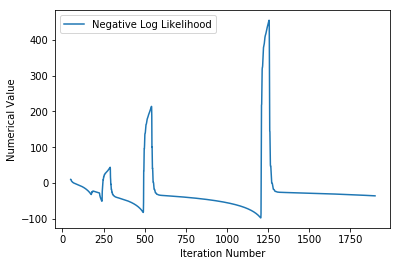

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


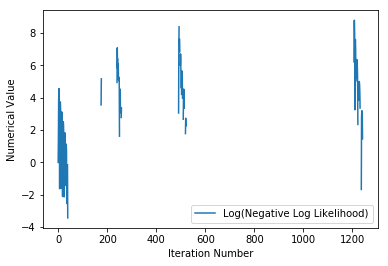

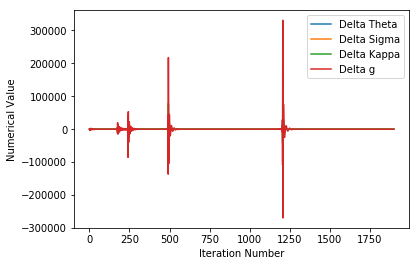

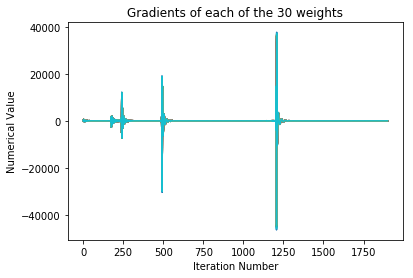

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


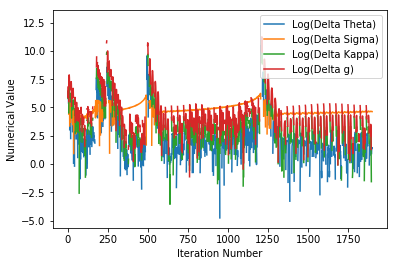

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log


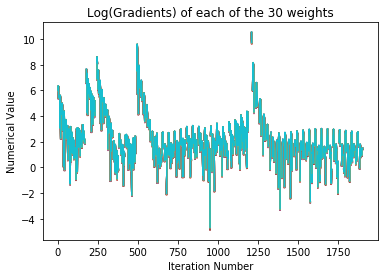

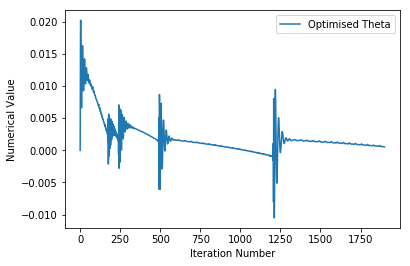

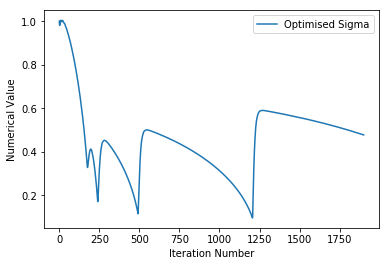

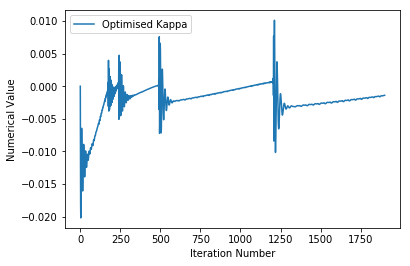

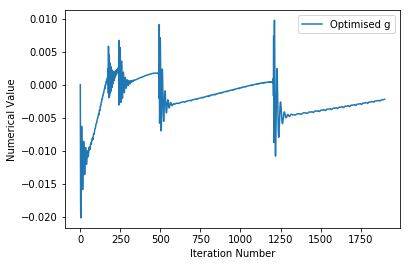

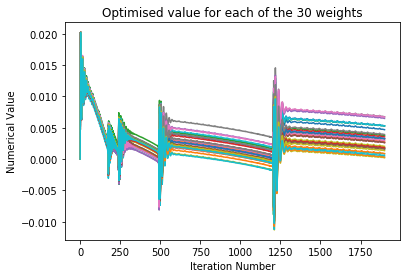

In [0]:
#####Plots for convergence
plt.plot([np.mean(errors[i-50:i]) for i in range(len(errors))], label = "Negative Log Likelihood")
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(errors), label = "Log(Negative Log Likelihood)")
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(gradients[:,0], label='Delta Theta')
plt.plot(gradients[:,1], label='Delta Sigma')
plt.plot(gradients[:,2], label='Delta Kappa')
plt.plot(gradients[:,3], label='Delta g')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(gradients_weights, label='Delta Weights')
plt.title('Gradients of each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(gradients[:,0]), label='Log(Delta Theta)')
plt.plot(np.log(gradients[:,1]), label='Log(Delta Sigma)')
plt.plot(np.log(gradients[:,2]), label='Log(Delta Kappa)')
plt.plot(np.log(gradients[:,3]), label='Log(Delta g)')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(gradients_weights), label='Log(Delta Weights)')
plt.title('Log(Gradients) of each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_theta, label='Optimised Theta')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_sigma, label='Optimised Sigma')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_kappa, label='Optimised Kappa')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_little_g, label='Optimised g')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_weights_vector, label='Optimised Weights')
plt.title('Optimised value for each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()



I will now take the optmised parameters and calculate the limits using Kramers' escape formula. I will also simplify the problem and do this without signals as it's easier for the sake of this exercise.

In [0]:
####Declaring Lambda functions for the derivatives of V w.r.t y
def V_over_y_t(theta, sigma, kappa, little_g):
    """
    delta_V_over_delta_y_t - compute the partial derivative of V with respect to y that is used in the minimum likelihood equation.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    Return:
    V_over_y_t_function - returns the partial derivative vector at a given time index
    """
    #V_over_y_t_function = (((tf.pow(sigma, 2)/2.0) - theta -  (tf.tensordot( weights_vector,signals,1)))* stock_price  ) + (kappa*tf.exp(stock_price)) + (0.5*little_g*tf.exp(2.0*stock_price))
    V_over_y_t_function = lambda stock_price: (((tf.pow(sigma, 2)/2.0) - theta)* stock_price) + (kappa*tf.exp(stock_price)) + (0.5*little_g*tf.exp(2.0*stock_price))
    return V_over_y_t_function 

def delta_V_over_delta_y_t(theta, sigma, kappa, little_g):
    """
    delta_V_over_delta_y_t - compute the partial derivative of V with respect to y that is used in the minimum likelihood equation.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    Return:
    delta_V_over_delta_y_t_function - returns the partial derivative vector at a given time index
    """
    #delta_V_over_delta_y_t_function = (((tf.pow(sigma, 2)/2.0) - theta -  (tf.tensordot( weights_vector,signals,1)))) + (kappa*tf.exp(stock_price)) + (little_g*tf.exp(2.0*stock_price))
    delta_V_over_delta_y_t_function = lambda stock_price: (((tf.pow(sigma, 2)/2.0) - theta)) + (kappa*tf.exp(stock_price)) + (little_g*tf.exp(2.0*stock_price))
    return delta_V_over_delta_y_t_function 

def double_delta_V_over_double_delta_y_t(kappa, little_g):
    """
    delta_V_over_delta_y_t - compute the partial derivative of V with respect to y that is used in the minimum likelihood equation.

    Arguments:
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    Return:
    double_delta_V_over_double_delta_y_t_function - returns the partial derivative vector at a given time index
    """
    double_delta_V_over_double_delta_y_t_function = lambda stock_price: (kappa*tf.exp(stock_price))  + (2.0*little_g*tf.exp(2.0*stock_price))
    return double_delta_V_over_double_delta_y_t_function 

1.9264178


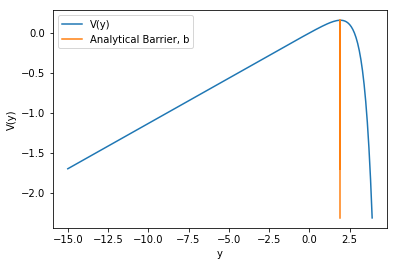

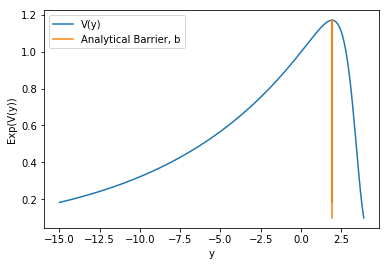

In [0]:
best_fit_theta = tf.constant(obs_theta[-1], dtype = tf.float32)
best_fit_sigma = tf.constant(obs_sigma[-1], dtype = tf.float32)
best_fit_kappa = tf.constant(obs_kappa[-1], dtype = tf.float32)
best_fit_little_g = tf.constant(obs_little_g[-1], dtype = tf.float32)

with tf.Session() as sess:
    analytical_gradient_equal_zero = tf.log(tf.sqrt(((best_fit_kappa**2)/(4.0*(best_fit_little_g**2))) - ((best_fit_sigma**2)/(2.0*best_fit_little_g)) + (best_fit_theta/best_fit_little_g) ) - ((best_fit_kappa)/(2.0*best_fit_little_g)))
    max_point_barrier = sess.run(analytical_gradient_equal_zero)
    print(sess.run(analytical_gradient_equal_zero))
    V_y = V_over_y_t(best_fit_theta, best_fit_sigma, best_fit_kappa, best_fit_little_g)
    V_y_all = sess.run([V_y(tf.constant(x, dtype=tf.float32)) for x in np.arange(-15,4, 0.1)])
    sess.close()

plt.plot(np.arange(-15,4, 0.1), V_y_all, label='V(y)')
plt.plot(max_point_barrier*np.ones(len(V_y_all)),V_y_all, label='Analytical Barrier, b')
plt.xlabel('y')
plt.ylabel('V(y)')
plt.legend(loc='best')
plt.show()

plt.plot(np.arange(-15,4, 0.1), np.exp(V_y_all), label='V(y)')
plt.plot(max_point_barrier*np.ones(len(V_y_all)),np.exp(V_y_all), label='Analytical Barrier, b')
plt.xlabel('y')
plt.ylabel('Exp(V(y))')
plt.legend(loc='best')
plt.show()

V(b) = 0.15701324
Sigma Squared Halved = 0.1139387
So V(a) << 0.04307454
Hence there are two values of a for which we need to numerically solve for


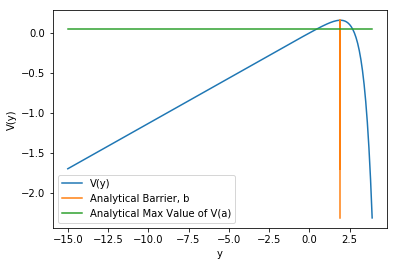

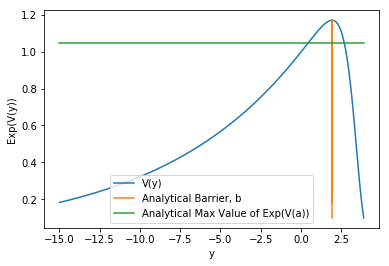

In [0]:
peak_b_value = tf.constant(max_point_barrier, dtype = tf.float32)

with tf.Session() as sess:
    V_y = V_over_y_t(best_fit_theta, best_fit_sigma, best_fit_kappa, best_fit_little_g)
    print("V(b) =", sess.run(V_y(peak_b_value)))
    print("Sigma Squared Halved =", sess.run( (best_fit_sigma**2)/2.0 ))
    V_a_max = sess.run(V_y(peak_b_value)-((best_fit_sigma**2)/2.0))
    print("So V(a) <<",sess.run(V_y(peak_b_value)-((best_fit_sigma**2)/2.0)))
    sess.close()

print("Hence there are two values of a for which we need to numerically solve for")
plt.plot(np.arange(-15,4, 0.1), V_y_all, label='V(y)')
plt.plot(max_point_barrier*np.ones(len(V_y_all)),V_y_all, label='Analytical Barrier, b')
plt.plot(np.arange(-15,4, 0.1), V_a_max*np.ones(len(np.arange(-15,4, 0.1))), label='Analytical Max Value of V(a)') 
plt.xlabel('y')
plt.ylabel('V(y)')
plt.legend(loc='best')
plt.show()

plt.plot(np.arange(-15,4, 0.1), np.exp(V_y_all), label='V(y)')
plt.plot(max_point_barrier*np.ones(len(V_y_all)),np.exp(V_y_all), label='Analytical Barrier, b')
plt.plot(np.arange(-15,4, 0.1), np.exp(V_a_max)*np.ones(len(np.arange(-15,4, 0.1))), label='Analytical Max Value of Exp(V(a))') 
plt.xlabel('y')
plt.ylabel('Exp(V(y))')
plt.legend(loc='best')
plt.show()

starting at a: -1.0
Final numerical_error: 0.0006515421
Final a_one: 0.42446503
Hence a <  0.42446503
starting at a: 4.0
Final numerical_error: 0.0014591143
Final a_two: 2.6937084
Hence a >  2.6937084


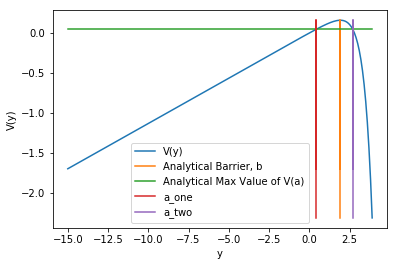

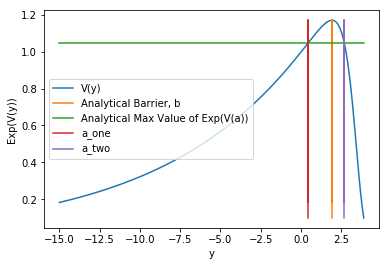

In [0]:
####Declaring Hyperparamters
learning_rate = 0.1
training_epochs = 5000

####Declaring the first "a" variable placeholders to find the range of "a".
a_one = tf.Variable(initial_value=-1.0, dtype=tf.float32)
V_a_max_value = tf.constant(V_a_max, dtype = tf.float32)

####Creating the error term
V_y = V_over_y_t(best_fit_theta, best_fit_sigma, best_fit_kappa, best_fit_little_g)
error = tf.abs(V_y(a_one) - V_a_max_value)

####The Adam Gradient Descent Optimizer does the heavy lifting
train_op = tf.train.AdamOptimizer(learning_rate).minimize(error)

####Normal TensorFlow - initialize values, create a session and run the model
model = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(model)
    print("starting at", "a:", sess.run(a_one))
    
    for epoch in range(training_epochs):
        op, numerical_error = sess.run([train_op, error])
        #print("numerical_error:", numerical_error)
        #print("a_one:", sess.run(a_one))
    print("Final numerical_error:", numerical_error)    
    print("Final a_one:", sess.run(a_one))
    print("Hence a < ", sess.run(a_one))
    final_a_one = sess.run(a_one)
    sess.close()
    
####Declaring the second "a" variable placeholders to find the range of "a".
a_two = tf.Variable(initial_value=4.0, dtype=tf.float32)   

####Creating the error term
V_y = V_over_y_t(best_fit_theta, best_fit_sigma, best_fit_kappa, best_fit_little_g)
error = tf.abs(V_y(a_two) - V_a_max_value)

####The Adam Gradient Descent Optimizer does the heavy lifting
train_op = tf.train.AdamOptimizer(learning_rate).minimize(error)

####Normal TensorFlow - initialize values, create a session and run the model
model = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(model)
    print("starting at", "a:", sess.run(a_two))
    
    for epoch in range(training_epochs):
        op, numerical_error = sess.run([train_op, error])
        #print("numerical_error:", numerical_error)
        #print("a_two:", sess.run(a_two))
    print("Final numerical_error:", numerical_error)
    print("Final a_two:", sess.run(a_two))
    print("Hence a > ", sess.run(a_two))
    final_a_two = sess.run(a_two)
    sess.close()

plt.plot(np.arange(-15,4, 0.1), V_y_all, label='V(y)')
plt.plot(max_point_barrier*np.ones(len(V_y_all)),V_y_all, label='Analytical Barrier, b')
plt.plot(np.arange(-15,4, 0.1), V_a_max*np.ones(len(np.arange(-15,4, 0.1))), label='Analytical Max Value of V(a)') 
plt.plot(final_a_one*np.ones(len(V_y_all)),V_y_all, label='a_one')
plt.plot(final_a_two*np.ones(len(V_y_all)),V_y_all, label='a_two')
plt.xlabel('y')
plt.ylabel('V(y)')
plt.legend(loc='best')
plt.show()

plt.plot(np.arange(-15,4, 0.1), np.exp(V_y_all), label='V(y)')
plt.plot(max_point_barrier*np.ones(len(V_y_all)),np.exp(V_y_all), label='Analytical Barrier, b')
plt.plot(np.arange(-15,4, 0.1), np.exp(V_a_max)*np.ones(len(np.arange(-15,4, 0.1))), label='Analytical Max Value of Exp(V(a))')
plt.plot(final_a_one*np.ones(len(V_y_all)),np.exp(V_y_all), label='a_one')
plt.plot(final_a_two*np.ones(len(V_y_all)),np.exp(V_y_all), label='a_two')
plt.xlabel('y')
plt.ylabel('Exp(V(y))')
plt.legend(loc='best')
plt.show()


In [0]:
####Declaring Lambda functions for the Kramers Escape Formula
def kramers_escape_formula(theta, sigma, kappa, little_g, a, b):
    v_y_func = V_over_y_t(theta, sigma, kappa, little_g)
    double_delta_v_y_func = double_delta_V_over_double_delta_y_t(kappa, little_g)
    first_term = ((tf.sqrt(double_delta_v_y_func(a)*double_delta_v_y_func(b)))/(2.0*3.14))
    second_term = tf.exp(-((2.0)/(sigma**2))*(v_y_func(b) - v_y_func(a)))
    return first_term*second_term

a_one_value = tf.constant(final_a_one, dtype = tf.float32)
a_two_value = tf.constant(final_a_two, dtype = tf.float32)
print("a one: ", final_a_one, "a two: ", final_a_two, "b: ", max_point_barrier)

with tf.Session() as sess:
    #print(sess.run(kramers_escape_formula(best_fit_theta, best_fit_sigma, best_fit_kappa, best_fit_little_g, tf.constant(3.0, dtype=tf.float32), peak_b_value)))
    r_all_left = sess.run([kramers_escape_formula(best_fit_theta, best_fit_sigma, best_fit_kappa, best_fit_little_g, tf.constant(x, dtype=tf.float32), peak_b_value) for x in np.arange(-10.0,final_a_one, 0.1)])
    r_all_right = sess.run([kramers_escape_formula(best_fit_theta, best_fit_sigma, best_fit_kappa, best_fit_little_g, tf.constant(x, dtype=tf.float32), peak_b_value) for x in np.arange(final_a_two,10.0, 0.1)])
    sess.close()

r_all = r_all_left, r_all_right
list_all = np.append(np.arange(-10.0,final_a_one, 0.1), np.arange(final_a_two,10.0, 0.1))


a one:  0.42446503 a two:  2.6937084 b:  1.9264178


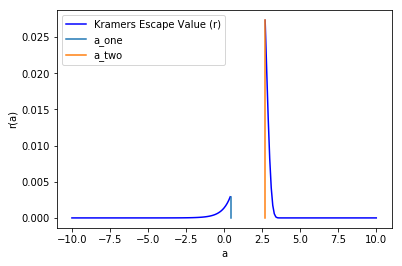

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


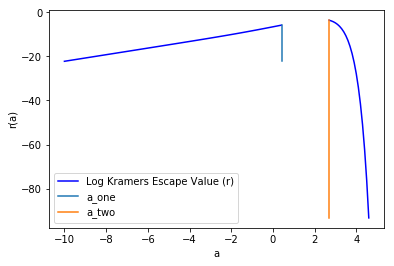

Hence r ranges from: 0.0 to 0.027314955


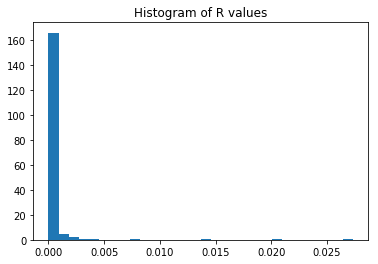

In [0]:
plt.plot(np.arange(-10.0,final_a_one, 0.1), r_all_left, color='blue')
plt.plot(np.arange(final_a_two,10.0, 0.1), r_all_right, label='Kramers Escape Value (r)', color='blue')
plt.plot(final_a_one*np.ones(len(r_all_left)),r_all_left, label='a_one')
plt.plot(final_a_two*np.ones(len(r_all_right)),r_all_right, label='a_two')
plt.xlabel('a')
plt.ylabel('r(a)')
plt.legend(loc='best')
plt.show()

plt.plot(np.arange(-10.0,final_a_one, 0.1), np.log(r_all_left), color='blue')
plt.plot(np.arange(final_a_two,10.0, 0.1), np.log(r_all_right), label='Log Kramers Escape Value (r)', color='blue')
plt.plot(final_a_one*np.ones(len(r_all_left)),np.log(r_all_left), label='a_one')
plt.plot(final_a_two*np.ones(len(r_all_right)),np.log(r_all_right), label='a_two')
plt.xlabel('a')
plt.ylabel('r(a)')
plt.legend(loc='best')
plt.show()

print("Hence r ranges from:", min(np.append(np.array(r_all_left), np.array(r_all_right)) ), "to", max(np.append(np.array(r_all_left), np.array(r_all_right)) ))

plt.hist(np.append(np.array(r_all_left), np.array(r_all_right)), bins=30)  # arguments are passed to np.histogram
plt.title("Histogram of R values")
plt.show()